In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [68]:
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

In [21]:
#load data
cancer = load_breast_cancer()

In [32]:
cancer.target_names

array(['malignant', 'benign'],
      dtype='<U9')

In [24]:
data = np.c_[cancer.data, cancer.target]
columns = np.append(cancer.feature_names, ["target"])
cancer_df=pd.DataFrame(data, columns=columns)

In [30]:
cancer_df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,559,560,561,562,563,564,565,566,567,568
mean radius,17.990000,20.570000,19.690000,11.420000,20.290000,12.450000,18.250000,13.710000,13.000000,12.460000,...,11.510000,14.050000,11.200000,15.220000,20.920000,21.560000,20.130000,16.600000,20.600000,7.760000
mean texture,10.380000,17.770000,21.250000,20.380000,14.340000,15.700000,19.980000,20.830000,21.820000,24.040000,...,23.930000,27.150000,29.370000,30.620000,25.090000,22.390000,28.250000,28.080000,29.330000,24.540000
mean perimeter,122.800000,132.900000,130.000000,77.580000,135.100000,82.570000,119.600000,90.200000,87.500000,83.970000,...,74.520000,91.380000,70.670000,103.400000,143.000000,142.000000,131.200000,108.300000,140.100000,47.920000
mean area,1001.000000,1326.000000,1203.000000,386.100000,1297.000000,477.100000,1040.000000,577.900000,519.800000,475.900000,...,403.500000,600.400000,386.000000,716.900000,1347.000000,1479.000000,1261.000000,858.100000,1265.000000,181.000000
mean smoothness,0.118400,0.084740,0.109600,0.142500,0.100300,0.127800,0.094630,0.118900,0.127300,0.118600,...,0.092610,0.099290,0.074490,0.104800,0.109900,0.111000,0.097800,0.084550,0.117800,0.052630
mean compactness,0.277600,0.078640,0.159900,0.283900,0.132800,0.170000,0.109000,0.164500,0.193200,0.239600,...,0.102100,0.112600,0.035580,0.208700,0.223600,0.115900,0.103400,0.102300,0.277000,0.043620
mean concavity,0.300100,0.086900,0.197400,0.241400,0.198000,0.157800,0.112700,0.093660,0.185900,0.227300,...,0.111200,0.044620,0.000000,0.255000,0.317400,0.243900,0.144000,0.092510,0.351400,0.000000
mean concave points,0.147100,0.070170,0.127900,0.105200,0.104300,0.080890,0.074000,0.059850,0.093530,0.085430,...,0.041050,0.043040,0.000000,0.094290,0.147400,0.138900,0.097910,0.053020,0.152000,0.000000
mean symmetry,0.241900,0.181200,0.206900,0.259700,0.180900,0.208700,0.179400,0.219600,0.235000,0.203000,...,0.138800,0.153700,0.106000,0.212800,0.214900,0.172600,0.175200,0.159000,0.239700,0.158700
mean fractal dimension,0.078710,0.056670,0.059990,0.097440,0.058830,0.076130,0.057420,0.074510,0.073890,0.082430,...,0.065700,0.061710,0.055020,0.071520,0.068790,0.056230,0.055330,0.056480,0.070160,0.058840


In [29]:
cancer_df.shape

(569, 31)

There are 569 rows and 31 columns. 

#### Check for null

In [34]:
# check for missing values
cancer_df.columns[cancer_df.isnull().any()]

Index([], dtype='object')

No missing values

# Random forest first try

### Train-Test Split

In [49]:
#split data into train and test set
from sklearn.model_selection import train_test_split
x_train, x_test,y_train, y_test = train_test_split(cancer_df.iloc[:,cancer_df.columns != 'target'],
                                                    cancer_df['target'],
                                                    test_size=0.25, 
                                                    random_state=100)

In [50]:
x_train.shape, y_train.shape

((426, 30), (426,))

In [51]:
x_test.shape, y_test.shape

((143, 30), (143,))

Find optimal parameters 

In [52]:
baseRF = RandomForestClassifier(n_estimators = 200, 
                               random_state = 0,
                               n_jobs = -1,
                               oob_score = True)

In [55]:
param_grid = {
    'min_samples_leaf' :[1,3,5], 
    'max_features' : ['auto',10,15,20,25,30],
    'criterion' : ['gini','entropy']
}

In [56]:
from sklearn.model_selection import GridSearchCV
cvRF = GridSearchCV(estimator=baseRF, param_grid=param_grid, cv=3, scoring='roc_auc')
cvRF.fit(x_train,y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': [1, 3, 5], 'max_features': ['auto', 10, 15, 20, 25, 30], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [57]:
cvRF.best_params_

{'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 5}

In [58]:
cvRF.best_score_

0.99145299145299159

Our best parameters are {'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 5}.
Our avgerage roc score of all folds is 0.99. 

#### Train the model with the best parameters 

In [59]:
model = RandomForestClassifier(n_estimators = 200, 
                               random_state = 0,
                               n_jobs = -1,
                               oob_score = True,
                               criterion = 'entropy',
                               min_samples_leaf = 5)
model.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

In [60]:
model.oob_score_

0.95539906103286387

In [63]:
pred_prob = model.predict_proba(x_test)
prob_lupus = [p[1] for p in pred_prob]
auc = roc_auc_score(y_test, prob_lupus)

In [64]:
print(auc)

0.993637110016


Our auc score is very good for this model.

#### Feature Importance 

In [67]:
fi = rf_feat_importance(model, x_train); fi[:20]

,cols,imp
27,worst concave points,0.151288
7,mean concave points,0.129892
20,worst radius,0.111253
22,worst perimeter,0.106497
23,worst area,0.094851
6,mean concavity,0.058635
2,mean perimeter,0.054862
3,mean area,0.039404
26,worst concavity,0.038906
13,area error,0.030503


In [91]:
colNames = list(fi.cols)[:10]
imp = list(fi.imp)[:10]

In [92]:
len(colNames )

10

In [93]:
def waterfall(index, data, Title = "Example Chart", x_lab = "Example Increments", y_lab = "Example values",
              formatting = "{:,.1f}", green_color='#29EA38', red_color='#FB3C62', blue_color='#24CAFF',
              sorted_value = False, threshold=None):
    
    #convert data and index to np.array
    index=np.array(index)
    data=np.array(data)
    
    #sorted by absolute value 
    if sorted_value: 
        abs_data = abs(data)
        data_order = np.argsort(abs_data)[::-1]
        data = data[data_order]
        index = index[data_order]
    
    #group contributors less than the threshold into 'other' 
    if threshold:
        
        abs_data = abs(data)
        threshold_v = abs_data.max()*threshold
        
        if threshold_v > abs_data.min():
            index = np.append(index[abs_data>=threshold_v],'other')
            data = np.append(data[abs_data>=threshold_v],sum(data[abs_data<threshold_v]))
    
    
    changes = {'amount' : data}
    
    def money(x, pos):
        'The two args are the value and tick position'
        return formatting.format(x)
    formatter = FuncFormatter(money)

    #Store data and create a blank series to use for the waterfall
    trans = pd.DataFrame(data=changes,index=index)
    blank = trans.amount.cumsum().shift(1).fillna(0)
    
    trans['positive'] = trans['amount'] > 0

    #Get the net total number for the final element in the waterfall
    total = trans.sum().amount
    trans.loc["Net"]= total
    blank.loc["Net"] = total

    #The steps graphically show the levels as well as used for label placement
    step = blank.reset_index(drop=True).repeat(3).shift(-1)
    step[1::3] = np.nan

    #When plotting the last element, we want to show the full bar,
    #Set the blank to 0
    blank.loc["Net"] = 0
    
    
    trans.loc[trans['positive'] > 1, 'positive'] = 99
    trans.loc[trans['positive'] < 0, 'positive'] = 99
    #trans.iloc[0, trans.columns.get_loc('positive')] = 99
    

    #Plot and label
    my_plot = trans['amount'].plot(kind='bar', stacked=True, bottom=blank,legend=None, 
                                   figsize=(10, 5), title=Title, 
                                   color=trans.positive.map({1: green_color, 0: red_color, 99:blue_color, 
                                                             100:"gray"}))
    #my_plot.plot(step.index, step.values,'k') #this makes the blank lines
    my_plot.set_xlabel("\n" + x_lab)
    my_plot.set_ylabel(y_lab + "\n")
    
    #Format the axis for dollars
    my_plot.yaxis.set_major_formatter(formatter)

    #Get the y-axis position for the labels
    y_height = trans.amount.cumsum().shift(1).fillna(0)

    #Get an offset so labels don't sit right on top of the bar
    max = abs(trans['amount'].max())
    min = abs(trans['amount'].min())
    
    temp = list(trans.amount)
    
    for i in range(len(temp)):
        if (i > 0) & (i < (len(temp) - 1)):
            temp[i] = temp[i] + temp[i-1]
    
    trans['temp'] = temp
            
    plot_max = trans['temp'].max()
    plot_min = trans['temp'].min()
    
    if max >= min:
        maxmax = max   
    else:
        maxmax = min
        
    pos_offset = maxmax / 50
    plot_offset = int(maxmax / 15) ## needs to me cumulative sum dynamic

    #Start label loop
    loop = 0
    for index, row in trans.iterrows():
        # For the last item in the list, we don't want to double count
        if row['amount'] == total:
            y = y_height[loop]
        else:
            y = y_height[loop] + row['amount']
        # Determine if we want a neg or pos offset
        if row['amount'] > 0:
            y += (pos_offset*1.2)
            my_plot.annotate(formatting.format(row['amount']),(loop,y),ha="center", color = 'g')
        else:
            y -= (pos_offset*2.3)
            my_plot.annotate(formatting.format(row['amount']),(loop,y),ha="center", color = 'r')
        loop+=1

    #Scale up the y axis so there is room for the labels
    my_plot.set_ylim(plot_min-2*int(plot_offset),plot_max+2*int(plot_offset))
    #Rotate the labels
    my_plot.set_xticklabels(trans.index,rotation=0)
    my_plot.axhline(0, color='black', linewidth = 0.6)

    return my_plot

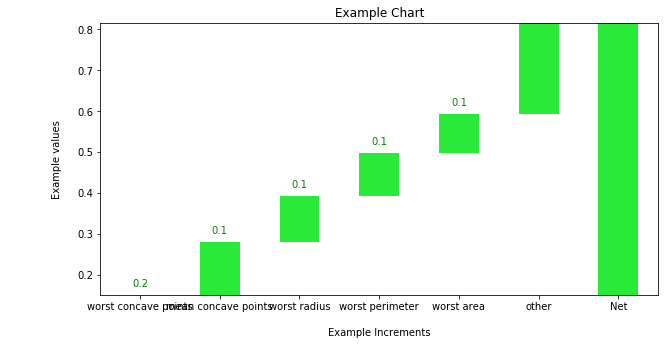

In [99]:
waterfall(colNames,imp, sorted_value=True,threshold=0.5)